# Project Title: PhonePe Transaction Insights

## Project Summary

### Problem Statement

In the rapidly evolving landscape of digital payment systems, gaining a comprehensive understanding of transaction dynamics, user engagement, and insurance-related data on platforms like PhonePe is paramount. Such insights are critical for enhancing service delivery, refining product offerings, and effectively targeting diverse user segments. This project focuses on analyzing and visualizing aggregated transaction values across various payment categories, mapping total values at granular state and district levels, and identifying the top-performing states, districts, and pincodes to inform strategic decisions.

---

### Database Tables Overview

The analysis leverages data from three primary categories of tables: `aggregated`, `map`, and `top`. These categories likely represent data summarized at different levels or for different purposes.

* **`aggregated` tables:** These tables contain data that has been summarized or aggregated, typically at a state, year, and quarter level. They focus on overall trends and totals.
* **`map` tables:** These tables likely store geographical data, often detailing information at a more granular level like districts, along with user or transaction metrics. The "map" in their name suggests a connection to spatial or regional analysis.
* **`top` tables:** These tables appear to contain data for the highest-ranking entities (e.g., top districts, top pincodes) based on certain metrics. They are pre-filtered or structured to easily identify top performers.

---

### Key Features Overview

The analysis utilizes several key features to dissect PhonePe's dynamics:

* **Geographical Identifiers (`state`, `district`, `name`/`pincode`):** These allow for granular analysis of performance and trends across different regions, from broad states down to specific pincodes, crucial for targeted strategies.
* **Temporal Identifiers (`year`, `quarter`):** Essential for time-series analysis, enabling the tracking of growth, trends, and seasonal variations in transactions and insurance over time.
* **Monetary Values (`amount`, `total_insurance`):** Represent the financial volume of transactions and insurance, used for assessing market size, revenue potential, and overall economic activity on the platform.
* **Counts/Volumes (`count`, `registeredUsers`, `appOpens`):** Quantify user base size, transaction frequency, and application engagement, providing insights into user adoption and activity levels.
* **Categorical/Behavioral (`transaction_type`, `brand`):** Classify transactions by type and users by device brand, helping understand user preferences, popular use cases, and the technological ecosystem influencing engagement.

---

### Business Use Cases:

* **Customer Segmentation:** Identify distinct user groups based on their spending habits and transaction behaviors to develop highly tailored marketing strategies and personalized service offerings.
* **Fraud Detection:** Analyze intricate transaction patterns and anomalies to proactively spot and prevent fraudulent activities, thereby enhancing the security and trustworthiness of the platform.
* **Geographical Insights:** Comprehend payment trends and user engagement variations at state and district levels to facilitate geographically targeted marketing campaigns, localized service improvements, and regional expansion initiatives.
* **Payment Performance:** Evaluate the popularity, volume, and value of different payment categories to guide strategic investments, prioritize feature development, and optimize payment processing infrastructure.
* **User Engagement:** Continuously monitor and analyze user activity metrics (e.g., app opens, transaction frequency) to develop proactive strategies that enhance user retention, boost satisfaction, and foster deeper platform integration.
* **Product Development:** Leverage data-driven insights derived from transaction and user behavior analyses to inform the creation of innovative new features, services, and product enhancements that directly address user needs and market demands.
* **Insurance Insights:** Specifically analyze insurance transaction data to identify trends in policy adoption, understand customer preferences, improve existing product offerings, and optimize the overall customer experience within the insurance vertical.
* **Marketing Optimization:** Refine and tailor marketing campaigns by basing them on detailed insights into user behavior, transaction patterns, and regional performance, ensuring maximum impact and return on investment.
* **Trend Analysis:** Examine transaction trends over various timeframes (e.g., quarterly, annually) to anticipate demand fluctuations, forecast market shifts, and prepare for seasonal or event-driven changes in user activity.
* **Competitive Benchmarking:** Compare PhonePe's performance metrics against industry benchmarks and key competitors to identify areas of strength, pinpoint opportunities for improvement, and maintain a competitive edge in the digital payments market.

## Data Overview

**Supress Warnings**

In [42]:
# Suppress all warning messages
import warnings
warnings.filterwarnings("ignore")

### Import Libraries

In [43]:
# Import required libraries
import os           # for file/directory operations
import json         # to read JSON files
import numpy as np  # numerical operations
import pandas as pd # data manipulation
import sqlite3      # SQLite database operations
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns            # for advanced visualizations

### GitHub Dataset Cloning

In [44]:
# Clone the PhonePe Pulse GitHub repository
!git clone https://github.com/PhonePe/pulse.git

fatal: destination path 'pulse' already exists and is not an empty directory.


### PhonePe Data to SQLite

In [45]:
# Set base directory path for data
base_path = '/kaggle/working/pulse/data'

# Initialize containers for different tables
tables = {
    "aggregated_user": [],
    "aggregated_transaction": [],
    "aggregated_insurance": [],
    "map_user": [],
    "map_transaction": [],
    "map_insurance": [],
    "top_user": [],
    "top_map": [],
    "top_insurance": []
}

# Extract state, year, and quarter from a given file path
def extract_state_year_quarter(path):
    parts = path.split(os.sep)
    state = parts[-3]
    year = parts[-2]
    quarter = int(parts[-1].replace('.json', ''))
    return state, int(year), quarter

#### Aggregated Tables

In [46]:
# Parse aggregated data for user, transaction, and insurance categories
for category in ['user', 'transaction', 'insurance']:
    agg_path = os.path.join(base_path, 'aggregated', category, 'country', 'india', 'state')
    for state in os.listdir(agg_path):
        for year in os.listdir(os.path.join(agg_path, state)):
            for file in os.listdir(os.path.join(agg_path, state, year)):
                fpath = os.path.join(agg_path, state, year, file)
                with open(fpath) as f:
                    data = json.load(f)
                    state_, year_, quarter_ = extract_state_year_quarter(fpath)

                    if category == 'user':
                        # Extract user device brand data
                        user_data = data.get('data', {}).get('usersByDevice')
                        if isinstance(user_data, list):
                            for entry in user_data:
                                tables['aggregated_user'].append({
                                    "state": state_,
                                    "year": year_,
                                    "quarter": quarter_,
                                    "brand": entry.get('brand'),
                                    "count": entry.get('count'),
                                    "percentage": entry.get('percentage')
                                })
                    else:
                        # Extract transaction or insurance data
                        txn_data = data.get('data', {}).get('transactionData', [])
                        for txn in txn_data:
                            tables[f'aggregated_{category}'].append({
                                "state": state_,
                                "year": year_,
                                "quarter": quarter_,
                                "transaction_type": txn.get('name'),
                                "count": txn['paymentInstruments'][0].get('count'),
                                "amount": txn['paymentInstruments'][0].get('amount')
                            })

#### Map Tables

In [47]:
# Parse map data for user, transaction, and insurance categories
for category in ['user', 'transaction', 'insurance']:
    map_path = os.path.join(base_path, 'map', category, 'hover', 'country', 'india', 'state')
    for state in os.listdir(map_path):
        for year in os.listdir(os.path.join(map_path, state)):
            for file in os.listdir(os.path.join(map_path, state, year)):
                fpath = os.path.join(map_path, state, year, file)
                with open(fpath) as f:
                    data = json.load(f)
                    state_, year_, quarter_ = extract_state_year_quarter(fpath)

                    table_key = f"map_{category if category != 'transaction' else 'transaction'}"

                    if category == 'user':
                        # Extract user data at district level
                        hover_data = data.get('data', {}).get('hoverData', {})
                        for district, values in hover_data.items():
                            tables[table_key].append({
                                "state": state_,
                                "district": district,
                                "year": year_,
                                "quarter": quarter_,
                                "registeredUsers": values.get('registeredUsers'),
                                "appOpens": values.get('appOpens')
                            })

                    else:
                        # Extract transaction/insurance metrics by district
                        hover_list = data.get('data', {}).get('hoverDataList', [])
                        for item in hover_list:
                            district = item.get('name')
                            metric_list = item.get('metric', [])

                            total_metric = None
                            if isinstance(metric_list, list):
                                total_metric = next(
                                    (m for m in metric_list if m.get('type') == 'TOTAL'),
                                    None
                                )

                            if total_metric:
                                tables[table_key].append({
                                    "state": state_,
                                    "district": district,
                                    "year": year_,
                                    "quarter": quarter_,
                                    "count": total_metric.get('count'),
                                    "amount": total_metric.get('amount')
                                })

#### Top Tables

In [48]:
# Parse top data for user, transaction, and insurance categories
for category in ['user', 'transaction', 'insurance']:
    top_path = os.path.join(base_path, 'top', category, 'country', 'india', 'state')
    for state in os.listdir(top_path):
        for year in os.listdir(os.path.join(top_path, state)):
            for file in os.listdir(os.path.join(top_path, state, year)):
                fpath = os.path.join(top_path, state, year, file)
                with open(fpath) as f:
                    data = json.load(f)
                    state_, year_, quarter_ = extract_state_year_quarter(fpath)

                    if category == 'user':
                        # Combine top districts and pincodes for users
                        districts = data.get('data', {}).get('districts', [])
                        pincodes = data.get('data', {}).get('pincodes', [])
                        for entry in districts + pincodes:
                            tables['top_user'].append({
                                "state": state_,
                                "year": year_,
                                "quarter": quarter_,
                                "name": entry.get('name'),
                                "registeredUsers": entry.get('registeredUsers')
                            })
                    else:
                        # Handle top transaction/insurance data
                        items = data.get('data', {}).get('districts') or data.get('data', {}).get('pincodes') or []
                        table_key = f"top_{category if category != 'transaction' else 'map'}"
                        for entry in items:
                            tables[table_key].append({
                                "state": state_,
                                "year": year_,
                                "quarter": quarter_,
                                "name": entry.get('entityName'),
                                "count": entry.get('metric', {}).get('count'),
                                "amount": entry.get('metric', {}).get('amount')
                            })

#### Database creation

In [49]:
# Create SQLite database and store parsed data into tables
conn = sqlite3.connect("phonepe_full_data.db")

for table_name, records in tables.items():
    df = pd.DataFrame(records)
    if not df.empty:
        # Save non-empty DataFrame to SQL table
        df.to_sql(table_name, conn, if_exists='replace', index=False)
        print(f"Created table: {table_name} ({len(df)} rows)")
    else:
        print(f"Skipped empty table: {table_name}")

Created table: aggregated_user (6732 rows)
Created table: aggregated_transaction (5034 rows)
Created table: aggregated_insurance (682 rows)
Created table: map_user (20608 rows)
Created table: map_transaction (20604 rows)
Created table: map_insurance (13876 rows)
Created table: top_user (18296 rows)
Created table: top_map (8296 rows)
Created table: top_insurance (5608 rows)


### Load PhonePe Tables into DataFrames

In [50]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect("phonepe_full_data.db")

# Load all 9 tables into DataFrames
df_aggregated_user = pd.read_sql("SELECT * FROM aggregated_user", conn)
df_aggregated_transaction = pd.read_sql("SELECT * FROM aggregated_transaction", conn)
df_aggregated_insurance = pd.read_sql("SELECT * FROM aggregated_insurance", conn)

df_map_user = pd.read_sql("SELECT * FROM map_user", conn)
df_map_transaction = pd.read_sql("SELECT * FROM map_transaction", conn)
df_map_insurance = pd.read_sql("SELECT * FROM map_insurance", conn)

df_top_user = pd.read_sql("SELECT * FROM top_user", conn)
df_top_map = pd.read_sql("SELECT * FROM top_map", conn)
df_top_insurance = pd.read_sql("SELECT * FROM top_insurance", conn)

### Preview First 5 Rows of All Tables

In [51]:
# Store all DataFrames in a dictionary for easy access and display
dfs = {
    "df_aggregated_user": df_aggregated_user,
    "df_aggregated_transaction": df_aggregated_transaction,
    "df_aggregated_insurance": df_aggregated_insurance,
    "df_map_user": df_map_user,
    "df_map_transaction": df_map_transaction,
    "df_map_insurance": df_map_insurance,
    "df_top_user": df_top_user,
    "df_top_map": df_top_map,
    "df_top_insurance": df_top_insurance
}

# Display basic info and first 5 rows of each DataFrame
for name, df in dfs.items():
    print(f"First 5 rows of {name} (rows: {df.shape[0]}, columns: {df.shape[1]}):")
    print(df.head())
    print("-" * 80)

First 5 rows of df_aggregated_user (rows: 6732, columns: 6):
              state  year  quarter    brand  count  percentage
0  himachal-pradesh  2018        2   Xiaomi  89506    0.283877
1  himachal-pradesh  2018        2  Samsung  49124    0.155801
2  himachal-pradesh  2018        2     Vivo  29637    0.093996
3  himachal-pradesh  2018        2     Oppo  28884    0.091608
4  himachal-pradesh  2018        2   Realme  14951    0.047418
--------------------------------------------------------------------------------
First 5 rows of df_aggregated_transaction (rows: 5034, columns: 6):
              state  year  quarter          transaction_type   count  \
0  himachal-pradesh  2018        2  Recharge & bill payments  385642   
1  himachal-pradesh  2018        2     Peer-to-peer payments  243436   
2  himachal-pradesh  2018        2         Merchant payments   27851   
3  himachal-pradesh  2018        2        Financial Services   11330   
4  himachal-pradesh  2018        2                  

### Check for Missing Values

In [52]:
# Check and display null value counts for each DataFrame
for name, df in dfs.items():
    print(f"Null value counts in {name} (rows: {df.shape[0]}):")
    print(df.isnull().sum())
    print("-" * 50)

Null value counts in df_aggregated_user (rows: 6732):
state         0
year          0
quarter       0
brand         0
count         0
percentage    0
dtype: int64
--------------------------------------------------
Null value counts in df_aggregated_transaction (rows: 5034):
state               0
year                0
quarter             0
transaction_type    0
count               0
amount              0
dtype: int64
--------------------------------------------------
Null value counts in df_aggregated_insurance (rows: 682):
state               0
year                0
quarter             0
transaction_type    0
count               0
amount              0
dtype: int64
--------------------------------------------------
Null value counts in df_map_user (rows: 20608):
state              0
district           0
year               0
quarter            0
registeredUsers    0
appOpens           0
dtype: int64
--------------------------------------------------
Null value counts in df_map_transacti

### View Columns

In [53]:
# Display column names of each DataFrame
for name, df in dfs.items():
    print(f"Columns in {name} (rows: {df.shape[0]}):")
    print(df.columns.tolist())
    print("_" * 80)

Columns in df_aggregated_user (rows: 6732):
['state', 'year', 'quarter', 'brand', 'count', 'percentage']
________________________________________________________________________________
Columns in df_aggregated_transaction (rows: 5034):
['state', 'year', 'quarter', 'transaction_type', 'count', 'amount']
________________________________________________________________________________
Columns in df_aggregated_insurance (rows: 682):
['state', 'year', 'quarter', 'transaction_type', 'count', 'amount']
________________________________________________________________________________
Columns in df_map_user (rows: 20608):
['state', 'district', 'year', 'quarter', 'registeredUsers', 'appOpens']
________________________________________________________________________________
Columns in df_map_transaction (rows: 20604):
['state', 'district', 'year', 'quarter', 'count', 'amount']
________________________________________________________________________________
Columns in df_map_insurance (rows: 13876

### DataFrames info

In [54]:
# Display detailed info (column types, non-null counts) for each DataFrame
for name, df in dfs.items():
    print(f"Info for {name} (rows: {df.shape[0]}):")
    df.info()
    print("-" * 80)

Info for df_aggregated_user (rows: 6732):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6732 entries, 0 to 6731
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   state       6732 non-null   object 
 1   year        6732 non-null   int64  
 2   quarter     6732 non-null   int64  
 3   brand       6732 non-null   object 
 4   count       6732 non-null   int64  
 5   percentage  6732 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.7+ KB
--------------------------------------------------------------------------------
Info for df_aggregated_transaction (rows: 5034):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5034 entries, 0 to 5033
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   state             5034 non-null   object 
 1   year              5034 non-null   int64  
 2   quarter           5034 non-null

## **Churn Prediction**

### Imports, helpers, and sanity checks

In [55]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier

# ---- EXPECTED dataframes already in memory (as per your screenshot):
# df_map_user:        ['state','district','year','quarter','registeredUsers','appOpens']
# df_map_transaction: ['state','district','year','quarter','count','amount']
# df_map_insurance:   ['state','district','year','quarter','count','amount']  (we'll rename to avoid conflicts)

for name in ["df_map_user","df_map_transaction","df_map_insurance"]:
    assert name in globals(), f"Missing dataframe: {name}"

def safe_div(n, d):
    """Safe division that handles 0/NaN."""
    n = n.astype(float)
    d = d.astype(float)
    out = np.divide(n, d, out=np.zeros_like(n, dtype=float), where=(d!=0) & (~np.isnan(d)))
    return out

### Build a single panel (merge user + transaction + insurance)

In [56]:
# Make a working copy and ensure correct dtypes
u = df_map_user.copy()
t = df_map_transaction.copy()
ins = df_map_insurance.copy()

# Standardize district text (avoid None/NaN mismatches)
for df in [u, t, ins]:
    df["district"] = df["district"].fillna("Unknown").astype(str)
    df["state"] = df["state"].astype(str)
    df["year"] = df["year"].astype(int)
    df["quarter"] = df["quarter"].astype(int)

# Rename overlapping cols
t = t.rename(columns={"count":"txn_count","amount":"txn_amount"})
ins = ins.rename(columns={"count":"ins_count","amount":"ins_amount"})

# Full outer merge on state/district/period keys
panel = (
    u.merge(t, on=["state","district","year","quarter"], how="outer")
     .merge(ins, on=["state","district","year","quarter"], how="outer")
)

# Fill missing numeric with 0 (aggregated data often has structural zeros)
for col in ["registeredUsers","appOpens","txn_count","txn_amount","ins_count","ins_amount"]:
    panel[col] = panel[col].fillna(0)

# Create a time index and a region key
panel["t"] = panel["year"]*4 + panel["quarter"]     # integer time id (works across years)
panel["region_id"] = panel["state"] + " | " + panel["district"]

# Sort cleanly
panel = panel.sort_values(["region_id","t"]).reset_index(drop=True)
panel.head()

,state,district,year,quarter,registeredUsers,appOpens,txn_count,txn_amount,ins_count,ins_amount,t,region_id
0,andaman-&-nicobar-islands,nicobar district,2024,3,7495.0,3219511.0,210536.0,3.724628e+08,51.0,68638.0,8099,andaman-&-nicobar-islands | nicobar district
1,andaman-&-nicobar-islands,nicobar district,2024,4,7698.0,1395115.0,232820.0,4.016765e+08,77.0,136595.0,8100,andaman-&-nicobar-islands | nicobar district
2,andaman-&-nicobar-islands,nicobars district,2018,1,262.0,0.0,528.0,1.139849e+06,0.0,0.0,8073,andaman-&-nicobar-islands | nicobars district
3,andaman-&-nicobar-islands,nicobars district,2018,2,351.0,0.0,1120.0,3.072437e+06,0.0,0.0,8074,andaman-&-nicobar-islands | nicobars district
4,andaman-&-nicobar-islands,nicobars district,2018,3,467.0,0.0,1471.0,6.387829e+06,0.0,0.0,8075,andaman-&-nicobar-islands | nicobars district


### Feature engineering (lags, growth, ratios, rolling stats)

In [57]:
def engineer_features(df):
    df = df.copy()
    g = df.groupby("region_id", group_keys=False)

    # Lags (t-1)
    for col in ["registeredUsers","appOpens","txn_count","txn_amount","ins_count","ins_amount"]:
        df[f"{col}_lag1"] = g[col].shift(1)

    # Current-period ratios
    df["avg_ticket"] = safe_div(df["txn_amount"], df["txn_count"])
    df["engagement"] = safe_div(df["txn_count"], df["registeredUsers"])
    df["ins_penetration"] = safe_div(df["ins_count"], df["registeredUsers"])

    # Lagged ratios
    df["avg_ticket_lag1"] = g["avg_ticket"].shift(1)
    df["engagement_lag1"] = g["engagement"].shift(1)
    df["ins_penetration_lag1"] = g["ins_penetration"].shift(1)

    # QoQ growth (momentum)
    def qoq(curr, prev):
        return safe_div(curr - prev, prev)

    df["users_qoq"]    = qoq(df["registeredUsers"], df["registeredUsers_lag1"])
    df["opens_qoq"]    = qoq(df["appOpens"],        df["appOpens_lag1"])
    df["count_qoq"]    = qoq(df["txn_count"],       df["txn_count_lag1"])
    df["amount_qoq"]   = qoq(df["txn_amount"],      df["txn_amount_lag1"])
    df["ticket_qoq"]   = qoq(df["avg_ticket"],      df["avg_ticket_lag1"])
    df["engage_qoq"]   = qoq(df["engagement"],      df["engagement_lag1"])
    df["ins_pen_qoq"]  = qoq(df["ins_penetration"], df["ins_penetration_lag1"])

    # Rolling 4-quarter stats (volatility/trend)
    for col in ["txn_count","txn_amount","engagement","avg_ticket","appOpens"]:
        df[f"{col}_roll4_mean"] = g[col].transform(lambda s: s.rolling(4, min_periods=2).mean())
        df[f"{col}_roll4_std"]  = g[col].transform(lambda s: s.rolling(4, min_periods=2).std())

    # Keep only rows with at least 1 lag (to avoid NaN explosions)
    df = df[df["registeredUsers_lag1"].notna()].reset_index(drop=True)
    return df

features_panel = engineer_features(panel)
features_panel.head()

,state,district,year,quarter,registeredUsers,appOpens,txn_count,txn_amount,ins_count,ins_amount,...,txn_count_roll4_mean,txn_count_roll4_std,txn_amount_roll4_mean,txn_amount_roll4_std,engagement_roll4_mean,engagement_roll4_std,avg_ticket_roll4_mean,avg_ticket_roll4_std,appOpens_roll4_mean,appOpens_roll4_std
0,andaman-&-nicobar-islands,nicobar district,2024,4,7698.0,1395115.0,232820.0,4.016765e+08,77.0,136595.0,...,221678.000000,15757.167512,3.870696e+08,2.065720e+07,29.167206,1.523126,1747.191416,31.007070,2307313.0,1.290043e+06
1,andaman-&-nicobar-islands,nicobars district,2018,2,351.0,0.0,1120.0,3.072437e+06,0.0,0.0,...,824.000000,418.607214,2.106143e+06,1.366546e+06,2.603075,0.831286,2451.025894,413.263390,0.0,0.000000e+00
2,andaman-&-nicobar-islands,nicobars district,2018,3,467.0,0.0,1471.0,6.387829e+06,0.0,0.0,...,1039.666667,476.605008,3.533372e+06,2.654180e+06,2.785348,0.667224,3081.519903,1130.469549,0.0,0.000000e+00
3,andaman-&-nicobar-islands,nicobars district,2018,4,536.0,0.0,1485.0,7.180859e+06,0.0,0.0,...,1151.000000,448.347336,4.445244e+06,2.832400e+06,2.781641,0.544837,3520.038808,1273.251582,0.0,0.000000e+00
4,andaman-&-nicobar-islands,nicobars district,2019,1,622.0,0.0,1539.0,7.236060e+06,0.0,0.0,...,1403.750000,191.425138,5.969296e+06,1.969732e+06,2.896394,0.339123,4155.785941,964.433434,0.0,0.000000e+00


### Label creation (regional churn next quarter)

In [58]:
# Adjustable thresholds (tune as needed)
TXN_DROP = 0.15   # 15% drop in txn_count next quarter
OPEN_DROP = 0.20  # 20% drop in appOpens next quarter

def create_labels(df):
    df = df.copy()
    g = df.groupby("region_id", group_keys=False)

    # Next-quarter values (t+1) to build "future" growth
    df["txn_count_lead1"] = g["txn_count"].shift(-1)
    df["appOpens_lead1"]  = g["appOpens"].shift(-1)

    # Growth to next quarter from CURRENT quarter
    df["count_next_qoq"] = safe_div(df["txn_count_lead1"] - df["txn_count"], df["txn_count"])
    df["opens_next_qoq"] = safe_div(df["appOpens_lead1"]  - df["appOpens"],  df["appOpens"])

    # Label: 1 if big drop next quarter (at-risk)
    df["churn"] = (
        (df["count_next_qoq"] < -TXN_DROP) |
        (df["opens_next_qoq"] < -OPEN_DROP)
    ).astype(int)

    # Remove last available quarter per region (no future to label)
    df = df[df["txn_count_lead1"].notna()].reset_index(drop=True)
    return df

labeled = create_labels(features_panel)
labeled[["state","district","year","quarter","churn"]].head()

,state,district,year,quarter,churn
0,andaman-&-nicobar-islands,nicobars district,2018,2,0
1,andaman-&-nicobar-islands,nicobars district,2018,3,0
2,andaman-&-nicobar-islands,nicobars district,2018,4,0
3,andaman-&-nicobar-islands,nicobars district,2019,1,0
4,andaman-&-nicobar-islands,nicobars district,2019,2,0


### Select features & time-aware train/holdout split

In [59]:
# Candidate feature columns (all numeric, drop identifiers & obvious leaks)
id_cols = ["state","district","year","quarter","region_id","t"]
leak_cols = [
    "txn_count_lead1","appOpens_lead1","count_next_qoq","opens_next_qoq"  # use only for labeling
]
target_col = "churn"

numeric_cols = [c for c in labeled.columns
                if c not in id_cols + leak_cols + [target_col]
                and pd.api.types.is_numeric_dtype(labeled[c])]

# Time split: use earliest ~80% time points for train, rest for test
all_t = np.sort(labeled["t"].unique())
split_idx = int(len(all_t) * 0.8)
train_t = set(all_t[:split_idx])
test_t  = set(all_t[split_idx:])

train_df = labeled[labeled["t"].isin(train_t)].copy()
test_df  = labeled[labeled["t"].isin(test_t)].copy()

X_train, y_train = train_df[numeric_cols], train_df[target_col]
X_test,  y_test  = test_df[numeric_cols],  test_df[target_col]

X_train.shape, X_test.shape

((14640, 35), (4283, 35))

### Train models (Logistic Regression & HistGradientBoosting) + core metrics

In [60]:
# ---- Model 1: Interpretable baseline (LogReg)
logreg = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # sparse-safe
    ("clf", LogisticRegression(max_iter=200, n_jobs=None))
])
logreg.fit(X_train, y_train)
p_log = logreg.predict_proba(X_test)[:,1]

# ---- Model 2: Strong baseline (tree boosting, built into sklearn)
hgb = HistGradientBoostingClassifier(max_depth=None, learning_rate=0.1, max_iter=300)
hgb.fit(X_train, y_train)
p_hgb = hgb.predict_proba(X_test)[:,1]

def report_metrics(name, y_true, y_score, thr=0.5):
    roc = roc_auc_score(y_true, y_score)
    ap  = average_precision_score(y_true, y_score)
    y_pred = (y_score >= thr).astype(int)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    cm   = confusion_matrix(y_true, y_pred)
    print(f"\n{name}")
    print(f"ROC AUC: {roc:.4f} | PR AUC: {ap:.4f} | Precision@0.5: {prec:.4f} | Recall@0.5: {rec:.4f}")
    print("Confusion matrix @0.5:\n", cm)

report_metrics("LogReg", y_test, p_log, thr=0.5)
report_metrics("HGB",    y_test, p_hgb, thr=0.5)


LogReg
ROC AUC: 0.6784 | PR AUC: 0.5443 | Precision@0.5: 0.6783 | Recall@0.5: 0.2575
Confusion matrix @0.5:
 [[2758  166]
 [1009  350]]

HGB
ROC AUC: 0.6933 | PR AUC: 0.5553 | Precision@0.5: 0.5122 | Recall@0.5: 0.4643
Confusion matrix @0.5:
 [[2323  601]
 [ 728  631]]


### Precision@K and Decile Lift (business ranking metrics)

In [61]:
import numpy as np
import pandas as pd

# --- Helper functions ---
def precision_at_k(y_true, y_score, k=0.1):
    """Precision among the top-k fraction by score."""
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_score = pd.Series(y_score).reset_index(drop=True)

    n = len(y_score)
    k_n = max(1, int(np.ceil(k * n)))
    idx = np.argsort(-y_score)[:k_n]
    return y_true.iloc[idx].mean()

def safe_div(a, b):
    return a / b if b != 0 else 0

def decile_lift_table(y_true, y_score):
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_score = pd.Series(y_score).reset_index(drop=True)

    df = pd.DataFrame({"y": y_true, "score": y_score})

    df["decile"] = pd.qcut(df["score"], 10, labels=False, duplicates="drop")

    agg = (
        df.groupby("decile")
          .agg(
              n=("y", "size"),
              churn_rate=("y", "mean"),
              avg_score=("score", "mean")
          )
          .reset_index()
          .sort_values("decile", ascending=False)
    )

    overall = df["y"].mean()
    agg["lift"] = agg["churn_rate"].apply(lambda x: safe_div(x, overall))
    return agg, overall


# --- Evaluation on your models ---
# Logistic Regression
p_at_10_log = precision_at_k(y_test, p_log, k=0.10)
table_log, base_log = decile_lift_table(y_test, p_log)
print(f"\nLogReg — Precision@Top10%: {p_at_10_log:.4f} | Baseline churn: {base_log:.4f}")
display(table_log)

# Histogram Gradient Boosting
p_at_10_hgb = precision_at_k(y_test, p_hgb, k=0.10)
table_hgb, base_hgb = decile_lift_table(y_test, p_hgb)
print(f"\nHGB — Precision@Top10%: {p_at_10_hgb:.4f} | Baseline churn: {base_hgb:.4f}")
display(table_hgb)



LogReg — Precision@Top10%: 0.6993 | Baseline churn: 0.3173


,decile,n,churn_rate,avg_score,lift
9,9,429,0.699301,0.810058,2.203904
8,8,428,0.525701,0.445417,1.656790
7,7,428,0.385514,0.324806,1.214979
6,6,428,0.287383,0.257839,0.905712
5,5,428,0.200935,0.210081,0.633262
4,4,429,0.221445,0.165739,0.697903
3,3,428,0.198598,0.119492,0.625898
2,2,428,0.242991,0.068194,0.765805
1,1,428,0.184579,0.022789,0.581717
0,0,429,0.226107,0.001728,0.712595



HGB — Precision@Top10%: 0.6946 | Baseline churn: 0.3173


,decile,n,churn_rate,avg_score,lift
9,9,429,0.694639,0.934115,2.189211
8,8,428,0.453271,0.783347,1.428521
7,7,428,0.366822,0.589479,1.156071
6,6,428,0.322430,0.379906,1.016164
5,5,428,0.278037,0.219749,0.876258
4,4,429,0.291375,0.116670,0.918293
3,3,428,0.280374,0.053208,0.883621
2,2,428,0.231308,0.019421,0.728987
1,1,428,0.144860,0.006057,0.456538
0,0,429,0.109557,0.001829,0.345278


### Feature importance (permutation) for the chosen model

In [62]:
# Use the better model (HGB). Permutation Importance is model-agnostic and easy to explain.
perm = permutation_importance(hgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
imp = pd.DataFrame({
    "feature": numeric_cols,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)
display(imp.head(20))

,feature,importance_mean,importance_std
19,opens_qoq,0.084310,0.005927
34,appOpens_roll4_std,0.014639,0.002899
21,amount_qoq,0.011277,0.002044
7,appOpens_lag1,0.009293,0.001826
22,ticket_qoq,0.006491,0.001119
32,avg_ticket_roll4_std,0.005954,0.002158
10,ins_count_lag1,0.005440,0.001528
26,txn_count_roll4_std,0.004716,0.001864
28,txn_amount_roll4_std,0.004716,0.002553
5,ins_amount,0.004179,0.002228


### Score the latest available quarter and export for PowerBI

In [63]:
# We'll score the last observed quarter (features at t, predicting risk at t+1)
latest_t = features_panel["t"].max()

# Build features for the last t (some regions may lack lag -> engineer_features already applied)
latest_features = features_panel[features_panel["t"] == latest_t].copy()

# Keep same feature set (numeric_cols) and metadata for display
X_latest = latest_features[numeric_cols].copy()
meta_cols = ["state","district","year","quarter","region_id","t"]
meta_latest = latest_features[meta_cols].copy()

# Predict with best model (HGB)
latest_features["risk_score"] = hgb.predict_proba(X_latest)[:,1]

# Risk buckets for business users
latest_features["risk_bucket"] = pd.qcut(latest_features["risk_score"], 4, labels=["Low","Med","High","Very High"])

# Export CSV
cols_out = meta_cols + ["risk_score","risk_bucket",
                        "registeredUsers","appOpens","txn_count","txn_amount","avg_ticket","engagement"]
scored = latest_features[cols_out].sort_values("risk_score", ascending=False)
scored_path = "regional_churn_scores.csv"
scored.to_csv(scored_path, index=False)
print(f"Saved: {scored_path}\nRows: {len(scored)}")
display(scored.head(15))


Saved: regional_churn_scores.csv
Rows: 788


,state,district,year,quarter,region_id,t,risk_score,risk_bucket,registeredUsers,appOpens,txn_count,txn_amount,avg_ticket,engagement
4009,delhi,north east district,2024,4,delhi | north east district,8100,0.997604,Very High,1105024.0,58794760.0,45691738.0,6.642492e+10,1453.762177,41.349091
4063,delhi,shahdara district,2024,4,delhi | shahdara district,8100,0.997268,Very High,1217468.0,66103068.0,47755577.0,6.914688e+10,1447.933157,39.225324
13047,puducherry,puducherry district,2024,4,puducherry | puducherry district,8100,0.995738,Very High,524684.0,25122134.0,12635394.0,1.479933e+10,1171.260068,24.081912
14950,tamil-nadu,kancheepuram district,2024,4,tamil-nadu | kancheepuram district,8100,0.995615,Very High,879179.0,47822605.0,24243664.0,2.476077e+10,1021.329367,27.575345
4090,delhi,south district,2024,4,delhi | south district,8100,0.995584,Very High,1340531.0,59225653.0,70674362.0,6.602733e+10,934.247278,52.721169
15625,tamil-nadu,vellore district,2024,4,tamil-nadu | vellore district,8100,0.994644,Very High,710254.0,44700090.0,19721312.0,2.763707e+10,1401.380833,27.766562
3955,delhi,new delhi district,2024,4,delhi | new delhi district,8100,0.994537,Very High,1676758.0,74170415.0,104744325.0,1.026401e+11,979.911058,62.468362
3820,dadra-&-nagar-haveli-&-daman-&-diu,dadra and nagar haveli district,2024,4,dadra-&-nagar-haveli-&-daman-&-diu | dadra and...,8100,0.994335,Very High,390650.0,26580899.0,18535942.0,1.559742e+10,841.468826,47.448975
4144,delhi,south west district,2024,4,delhi | south west district,8100,0.992638,Very High,1452225.0,67178206.0,70519080.0,7.954638e+10,1128.012217,48.559335
5595,haryana,rewari district,2024,4,haryana | rewari district,8100,0.992555,Very High,838890.0,45721289.0,44363909.0,5.775734e+10,1301.899241,52.884060


### Conclusion & Recommendations

#### 1. Customer Distribution
- Classify users into Very High, High, Medium, and Low risk buckets.
- Focus retention efforts on Very High and High risk users.
- Maintain loyalty and explore growth opportunities with Low risk users.

#### 2. Customer Profiling
- Analyze demographics (`state`, `district`, `region_id`) to identify geographic hotspots.
- Examine usage patterns (`appOpens`, `txn_count`, `txn_amount`, `avg_ticket`, `engagement`) to understand behavior.
- Tailor interventions based on user profile:
  - Very High Risk in specific regions may need targeted offers or app experience improvements.
  - Low Risk users with high transaction amounts are ideal for upselling or premium offerings.

#### 3. Targeted Retention Strategies
- Very High Risk: Personalized retention campaigns, discount coupons, or incentives to increase engagement.
- High Risk: Re-engagement campaigns such as push notifications or loyalty points.
- Medium Risk: Preventive interventions, reminders, or rewards for consistent app usage.
- Low Risk: Loyalty programs, upselling opportunities, and referral incentives.

#### 4. Revenue and Engagement Projections
- Estimate potential revenue at risk per bucket using `txn_amount` or `avg_ticket`.
- Prioritize interventions where ROI is highest, typically focusing on Very High and High Risk users.

#### 5. Further Analytics
- Use model feature importance to identify key churn drivers (`engagement`, `txn_count`, `appOpens`).
- Cluster high-risk users by behavior for more personalized campaigns.
- Monitor churn trends over time (`year`/`quarter`) to adjust strategies proactively.

#### Conclusion
- The risk bucket classification enables targeted, data-driven retention strategies.
- Immediate focus should be on Very High and High Risk users, followed by Medium Risk.
- Combining behavioral and demographic insights allows for personalized interventions, reducing churn and maximizing customer lifetime value.


## Business Case Studies

### **Decoding Transaction Dynamics on PhonePe**

**Scenario:** PhonePe, a prominent digital payments platform, has observed varying transaction behaviors across different states, quarters, and payment categories, with some areas experiencing growth while others face stagnation. To address this, the leadership team requires a comprehensive understanding of these underlying patterns to formulate precise and effective business strategies.

**Objective:** This analysis aims to dissect PhonePe's transaction data to identify key trends, geographical strengths, and popular transaction types. By exploring transaction amounts across states, quarterly growth patterns, and volume distribution by transaction type, we seek to provide actionable insights that will guide PhonePe in optimizing its operational focus and strategic investments. The following plots and underlying SQL queries were developed to illuminate these critical aspects of transaction dynamics.

#### **Total Transaction Amount by State**

**SQL Query**

The SQL query calculates the **total transaction amount** for each **state** from the `aggregated_transaction` table. It does this by summing up the `amount` for all transactions belonging to the same `state` and then arranges the results to show states with the highest total amounts first.

In [64]:
# Total transaction amount per state from aggregated_transaction table
df_txn_state = pd.read_sql("""
SELECT state, SUM(amount) AS txn_amount
FROM aggregated_transaction
GROUP BY state
ORDER BY txn_amount DESC
""", conn)

df_txn_state

,state,txn_amount
0,telangana,4.165596e+13
1,karnataka,4.067872e+13
2,maharashtra,4.037420e+13
3,andhra-pradesh,3.466908e+13
4,uttar-pradesh,2.688521e+13
5,rajasthan,2.634324e+13
6,madhya-pradesh,1.912528e+13
7,bihar,1.790135e+13
8,west-bengal,1.558416e+13
9,odisha,1.226398e+13


**Visualization**

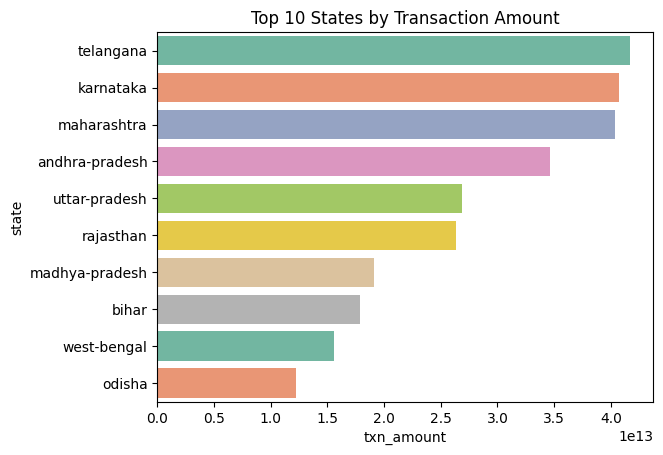

In [65]:
# Bar plot of top 10 states by total transaction amount
sns.barplot(data=df_txn_state.head(10), x='txn_amount', y='state', palette='Set2')
plt.title("Top 10 States by Transaction Amount")
plt.show()

The plot "Top 10 States by Transaction Amount" clearly indicates that **Telangana, Karnataka, and Maharashtra** lead significantly in total transaction amount, each surpassing ₹40 trillion. While there's a gradual decrease in transaction amounts down the list, all states within the top 10 contribute substantially, highlighting regional variations in digital transaction activity across India.

#### **Quarterly Transaction Trend (All India)**

**SQL Query**

This analysis examines the **transaction amount trend over time**. The SQL query first calculates the **total transaction amount** for each **year and quarter** by summing the `amount` from the `aggregated_transaction` table, grouping the data accordingly, and then ordering the results chronologically. Following this, the Python code creates a new column called `period` in the resulting DataFrame. This `period` column combines the `year` and `quarter` into a user-friendly 'YYYY-Qx' string format (e.g., '2023-Q1'), which is ideal for representing time series data for further analysis or visualization.

In [66]:
# Transaction amount trend over time (by year and quarter)
df_txn_time = pd.read_sql("""
SELECT year, quarter, SUM(amount) AS txn_amount
FROM aggregated_transaction
GROUP BY year, quarter
ORDER BY year, quarter
""", conn)

# Create period column in 'YYYY-Qx' format
df_txn_time['period'] = df_txn_time['year'].astype(str) + '-Q' + df_txn_time['quarter'].astype(str)

df_txn_time.head()

,year,quarter,txn_amount,period
0,2018,1,1.718334e+11,2018-Q1
1,2018,2,3.043742e+11,2018-Q2
2,2018,3,4.751015e+11,2018-Q3
3,2018,4,6.717362e+11,2018-Q4
4,2019,1,9.900214e+11,2019-Q1


**Visualization**

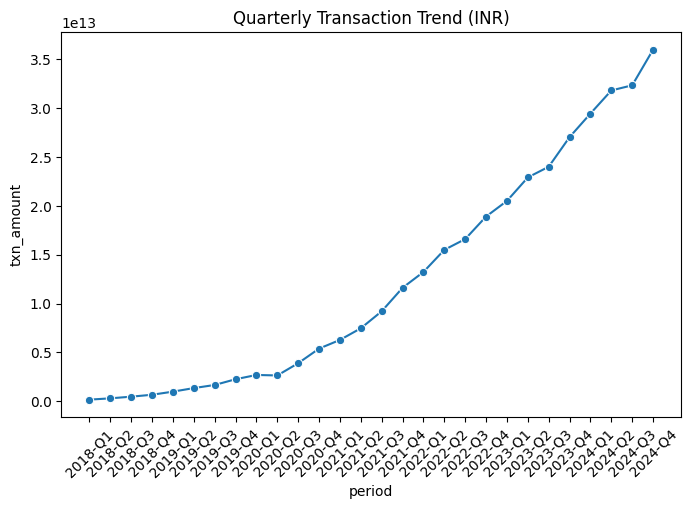

In [67]:
# Line plot showing quarterly transaction trend
plt.figure(figsize=(8, 5))  # Set figure size
sns.lineplot(data=df_txn_time, x='period', y='txn_amount', marker='o')
plt.xticks(rotation=45)
plt.title("Quarterly Transaction Trend (INR)")
plt.show()

The "Quarterly Transaction Trend (INR)" plot reveals a **consistent and significant upward trend** in total transaction amounts from Q1 2018 to Q4 2024. The growth appears to accelerate notably from early 2020 onwards, indicating a rapid expansion in digital transactions, with the latest quarter (2024-Q4) showing the highest transaction volume, approaching ₹3.5 quadrillion (3.5 x 10^13).

#### **Transaction Count by Type**

**SQL Query**

This code analyzes the **total transaction count per transaction type**. The SQL query first calculates the **sum of the `count`** (which represents transaction occurrences) for each `transaction_type` from the `aggregated_transaction` table, grouping the results by type and ordering them to show the most frequent types first. Subsequently, the Python code adds a new column named `log_txn_count` to the DataFrame. This column contains the **log-transformed values** of `txn_count` using `np.log1p` (which calculates $\log(1+x)$), a common technique applied to skewed count data to make its distribution more symmetrical and suitable for visualization.

In [68]:
# Total transaction count per transaction type
df_txn_type = pd.read_sql("""
SELECT transaction_type, SUM(count) AS txn_count
FROM aggregated_transaction
GROUP BY transaction_type
ORDER BY txn_count DESC
""", conn)

# Add log-transformed transaction count (for better visualization)
df_txn_type["log_txn_count"] = np.log1p(df_txn_type["txn_count"])

df_txn_type.head()


,transaction_type,txn_count,log_txn_count
0,Merchant payments,130238755487,25.592635
1,Peer-to-peer payments,85032446653,25.166299
2,Recharge & bill payments,19596755603,23.698630
3,Others,262050188,19.384047
4,Financial Services,154208943,18.853819


**Visualization**

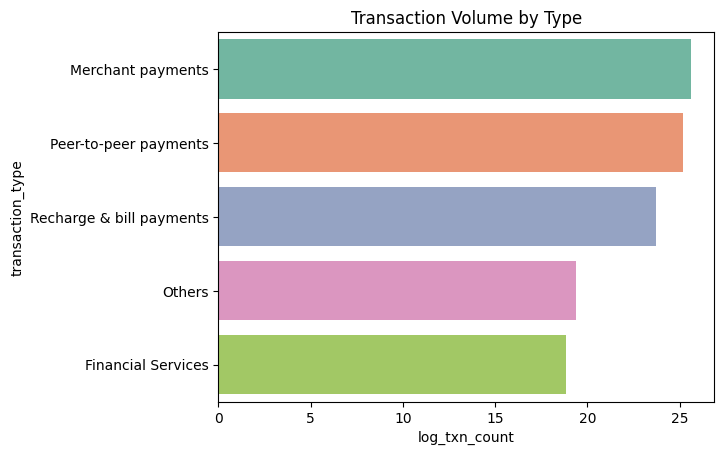

In [69]:
# Bar plot of transaction volume by type (log scale)
sns.barplot(data=df_txn_type, y='transaction_type', x='log_txn_count', palette="Set2")
plt.title("Transaction Volume by Type")
plt.show()

The "Transaction Volume by Type" plot, using a log-transformed count, highlights that **Merchant payments and Peer-to-peer payments** are the dominant transaction types, showing the highest volumes. "Recharge & bill payments" follow closely, while "Others" and "Financial Services" constitute a smaller, but still significant, portion of the total transaction volume. This indicates a strong preference for direct payments and utility transactions over other financial services on the platform.

### **Device Dominance and User Engagement Analysis**

**Scenario:** PhonePe seeks to deepen its understanding of user preferences and enhance app performance by analyzing user data across various device brands, regions, and time periods. Preliminary observations indicate significant regional variations in device usage trends, with some devices potentially being underutilized despite substantial registration numbers.

**Objective:** This analysis aims to shed light on the device ecosystem within PhonePe's user base and evaluate engagement patterns. By examining the overall top device brands by user count, identifying the most popular device brand within each state, and visualizing the relationship between app opens and registered users across states, we can gain critical insights into device market penetration, regional preferences, and the effectiveness of user engagement strategies. These findings will inform efforts to optimize app performance and tailor user experiences based on device and regional characteristics.

#### **Top Device Brands by User Count**

**SQL Query**

This code calculates the **total user count per mobile device brand**. The SQL query retrieves the **sum of `count`** (representing the number of users) for each unique `brand` from the `aggregated_user` table. It groups the data by `brand` to aggregate the user counts and then orders the results in descending order, showing the brands with the highest number of users first.

In [70]:
# Total user count per mobile device brand
df_device_brand = pd.read_sql("""
SELECT brand, SUM(count) AS total_users
FROM aggregated_user
GROUP BY brand
ORDER BY total_users DESC
""", conn)

df_device_brand

,brand,total_users
0,Xiaomi,869562617
1,Samsung,671603711
2,Vivo,625415019
3,Oppo,420250245
4,Others,282950234
5,Realme,219973222
6,Apple,95947314
7,Motorola,73340734
8,OnePlus,63677211
9,Huawei,57129693


**Visualization**

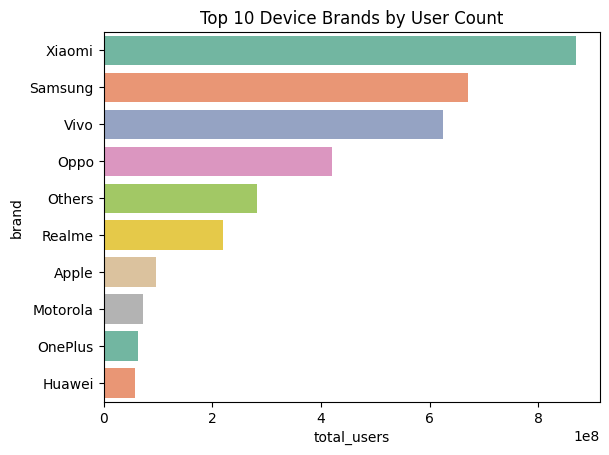

In [71]:
# Bar plot of top 10 mobile device brands by total user count
sns.barplot(data=df_device_brand.head(10), y='brand', x='total_users', palette="Set2")
plt.title("Top 10 Device Brands by User Count")
plt.show()

The "Top 10 Device Brands by User Count" plot clearly shows that **Xiaomi is the dominant mobile device brand** among PhonePe users, significantly leading with over 800 million users. Samsung and Vivo follow as the next major brands, indicating a strong presence of Chinese and South Korean manufacturers. Apple, Motorola, OnePlus, and Huawei represent a smaller, but still substantial, segment of the user base within the top 10, highlighting the diverse device ecosystem used by PhonePe's users.

#### **State with Top Brand**

**SQL Query**

This SQL query identifies the **top mobile device brand by user count for each state**. It first uses a Common Table Expression (CTE) named `ranked` to calculate the total user count for each `brand` within every `state`. Within this CTE, it then assigns a **rank** to each brand within its respective state based on its user count (highest user count gets rank 1). Finally, the outer query selects only those rows where the `rnk` is 1, effectively returning only the **single top device brand for each state**.

In [72]:
# Get the top device brand by user count in each state
df_top_brands_state = pd.read_sql("""
WITH ranked AS (
    SELECT state, brand, SUM(count) AS user_count,
           RANK() OVER (PARTITION BY state ORDER BY SUM(count) DESC) AS rnk
    FROM aggregated_user
    GROUP BY state, brand
)
SELECT * FROM ranked WHERE rnk = 1
""", conn)

df_top_brands_state

,state,brand,user_count,rnk
0,andaman-&-nicobar-islands,Xiaomi,148752,1
1,andhra-pradesh,Xiaomi,56579876,1
2,arunachal-pradesh,Xiaomi,652564,1
3,assam,Xiaomi,10092046,1
4,bihar,Xiaomi,47850275,1
5,chandigarh,Xiaomi,1235478,1
6,chhattisgarh,Xiaomi,12483445,1
7,dadra-&-nagar-haveli-&-daman-&-diu,Vivo,919286,1
8,delhi,Xiaomi,33195661,1
9,goa,Xiaomi,1725922,1


**Visualization**

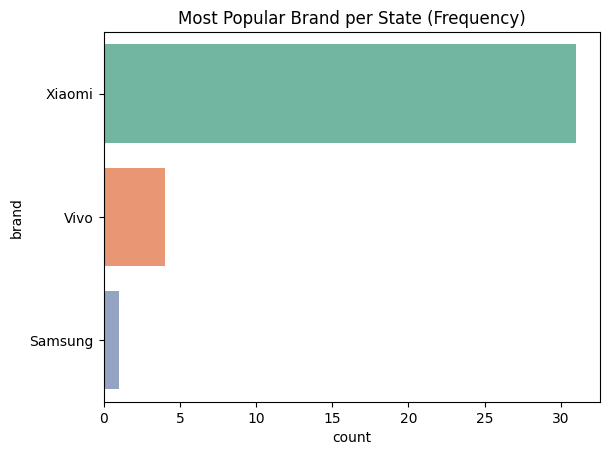

In [73]:
# Count plot of the most popular device brands across states
sns.countplot(
    data=df_top_brands_state,
    y='brand',
    order=df_top_brands_state['brand'].value_counts().index,
    palette="Set2"
)
plt.title("Most Popular Brand per State (Frequency)")
plt.show()


The "Most Popular Brand per State (Frequency)" plot indicates a highly dominant presence of **Xiaomi**, which is the top brand in over 30 states. Vivo is a distant second, being the most popular in a handful of states, while Samsung's presence as the top brand in any single state is minimal. This suggests that while several brands have users, Xiaomi holds the strongest position in terms of being the primary choice across the majority of Indian states.

#### **App Opens vs Registered Users by State**

**SQL Query**

This SQL query calculates the **total number of registered users and app opens for each state**. It achieves this by summing the `registeredUsers` and `appOpens` columns from the `map_user` table, grouping these sums by `state`. Importantly, the `HAVING users > 0` clause then filters the results, ensuring that only states with **at least one registered user** are included in the final output.

In [74]:
# Total registered users and app opens per state from map_user table
df_user_open = pd.read_sql("""
SELECT state, SUM(registeredUsers) AS users, SUM(appOpens) AS opens
FROM map_user
GROUP BY state
HAVING users > 0
""", conn)

df_user_open.head()

,state,users,opens
0,andaman-&-nicobar-islands,1842465,170043693
1,andhra-pradesh,556747126,24728024309
2,arunachal-pradesh,8046446,1117277209
3,assam,111842317,9436508709
4,bihar,446115282,13608259251


**Visualization**

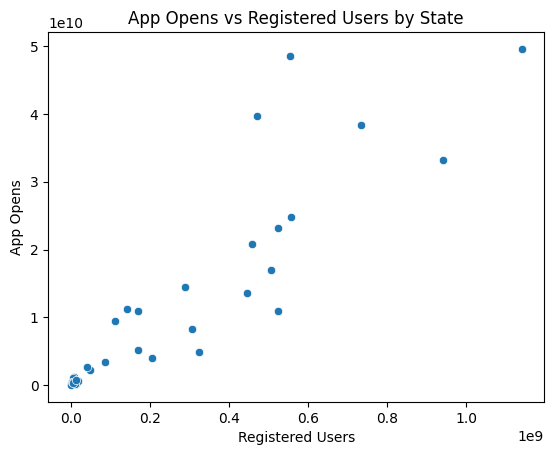

In [75]:
# Scatter plot showing relationship between registered users and app opens
sns.scatterplot(data=df_user_open, x='users', y='opens')
plt.title("App Opens vs Registered Users by State")
plt.xlabel("Registered Users")
plt.ylabel("App Opens")
plt.show()

The "App Opens vs Registered Users by State" scatter plot displays a **strong positive correlation** between the number of registered users and the number of app opens across different states. This indicates that states with a higher user base generally experience a proportionally higher volume of app engagements. The data points cluster along an upward trend, with some outliers having exceptionally high app opens for their user count, suggesting varying levels of engagement efficiency across states.

### **Insurance Penetration and Growth Potential Analysis**

**Scenario:** PhonePe's expansion into the insurance sector necessitates a clear understanding of its growth trajectory and identification of new opportunities for adoption. The company aims to analyze current patterns in insurance transactions to prioritize regions for targeted marketing campaigns and strategic partnerships.

**Objective:** This analysis provides insights into PhonePe's insurance business by examining key metrics across states and over time. By presenting the **top states by total insurance amount**, we identify current high-value markets. The **quarterly trend of insurance transaction amounts** illustrates the overall growth and health of the insurance segment. Furthermore, the **insurance share of total transactions per state** uncovers regions where insurance is a significant component of digital activity, or conversely, regions with low penetration but high overall transaction volume, thereby highlighting untapped growth potential and guiding strategic regional focus for future insurance initiatives.

#### **Insurance Amount by State**

**SQL Query**

This SQL query calculates the **total insurance amount for each state**. It achieves this by summing the `amount` column from the `aggregated_insurance` table for each unique `state`. The results are then grouped by `state` and ordered in descending order of `total_insurance`, presenting the states with the highest total insurance amounts first.

In [76]:
# Total insurance amount per state from aggregated_insurance table
df_ins_state = pd.read_sql("""
SELECT state, SUM(amount) AS total_insurance
FROM aggregated_insurance
GROUP BY state
ORDER BY total_insurance DESC
""", conn)

df_ins_state

,state,total_insurance
0,karnataka,2.743155e+09
1,maharashtra,2.363129e+09
2,uttar-pradesh,1.740346e+09
3,tamil-nadu,1.555507e+09
4,kerala,1.313719e+09
5,telangana,1.171060e+09
6,west-bengal,1.052463e+09
7,rajasthan,9.596539e+08
8,haryana,8.309812e+08
9,delhi,8.153652e+08


**Visualization**

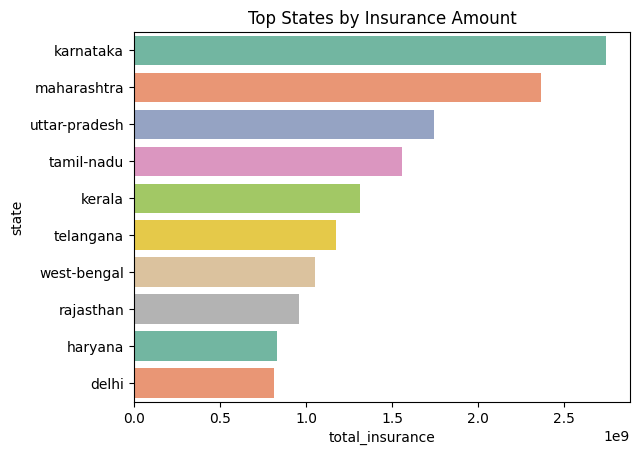

In [77]:
# Bar plot of top 10 states by total insurance amount
sns.barplot(data=df_ins_state.head(10), y='state', x='total_insurance', palette="Set2")
plt.title("Top States by Insurance Amount")
plt.show()

The "Top States by Insurance Amount" plot indicates that **Karnataka and Maharashtra are the leading states in terms of total insurance amount**, significantly surpassing others. Uttar Pradesh follows as the third highest. The amounts gradually decrease down the list, with states like Delhi and Haryana showing notably lower insurance volumes compared to the top performers. This highlights distinct regional disparities in insurance adoption or transaction volumes on PhonePe.

#### **Insurance Trend (Quarterly)**

**SQL Query**

This code analyzes the **quarterly trend of insurance amounts**. The SQL query first calculates the **total insurance amount** for each **year and quarter** by summing the `amount` from the `aggregated_insurance` table, grouping the data accordingly, and then ordering the results chronologically. Following this, the Python code creates a new column called `period` in the resulting DataFrame. This `period` column combines the `year` and `quarter` into a user-friendly 'YYYY-Qx' string format (e.g., '2023-Q1'), which is ideal for representing time series data for further analysis or visualization.

In [78]:
# Quarterly trend of insurance amounts
df_ins_qtr = pd.read_sql("""
SELECT year, quarter, SUM(amount) AS insurance_amount
FROM aggregated_insurance
GROUP BY year, quarter
ORDER BY year, quarter
""", conn)

# Create period column in 'YYYY-Qx' format
df_ins_qtr['period'] = df_ins_qtr['year'].astype(str) + '-Q' + df_ins_qtr['quarter'].astype(str)

df_ins_qtr.head()

,year,quarter,insurance_amount,period
0,2020,2,33732166.0,2020-Q2
1,2020,3,89495076.0,2020-Q3
2,2020,4,170979933.0,2020-Q4
3,2021,1,206295702.0,2021-Q1
4,2021,2,295065422.0,2021-Q2


**Visualization**

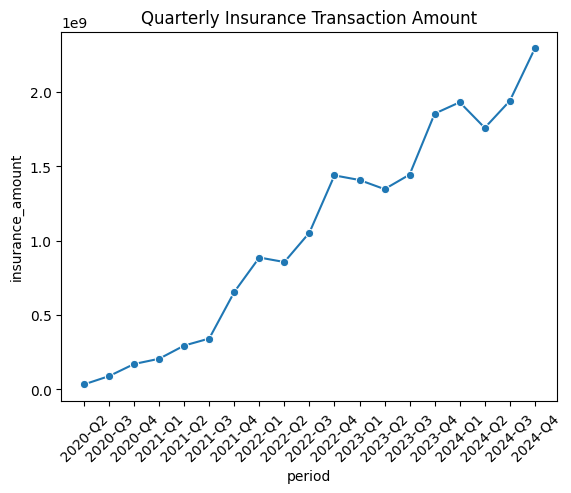

In [79]:
# Line plot showing quarterly insurance transaction amount trend
sns.lineplot(data=df_ins_qtr, x='period', y='insurance_amount', marker='o')
plt.title("Quarterly Insurance Transaction Amount")
plt.xticks(rotation=45)
plt.show()

The "Quarterly Insurance Transaction Amount" plot demonstrates a **consistent and generally strong upward trend** in insurance transaction amounts from Q2 2020 to Q4 2024. While there are minor fluctuations (e.g., slight dip in 2023-Q4 and 2024-Q2), the overall trajectory indicates a significant and sustained growth in the adoption and value of insurance transactions on the platform, reaching its peak in the latest observed quarter.

#### **Insurance Share of Total Transactions**

**SQL Query**

This SQL query calculates the **share of insurance transactions out of total transactions for each state**. It achieves this by first `JOIN`ing the `aggregated_transaction` and `aggregated_insurance` tables on matching `state`, `year`, and `quarter` to align the data. Then, for each `state`, it calculates the `insurance_share` as the ratio of the **sum of insurance amounts** to the **sum of all transaction amounts**, ensuring floating-point division using `*1.0`. Finally, the results are grouped by `state` and ordered to display states with the highest insurance share first.

In [80]:
# Calculate the share of insurance transactions out of total transactions per state
df_ins_share = pd.read_sql("""
SELECT at.state,
       SUM(ai.amount)*1.0 / SUM(at.amount) AS insurance_share
FROM aggregated_transaction at
JOIN aggregated_insurance ai ON at.state = ai.state AND at.year = ai.year AND at.quarter = ai.quarter
GROUP BY at.state
ORDER BY insurance_share DESC
""", conn)

df_ins_share

,state,insurance_share
0,kerala,0.002212
1,lakshadweep,0.002090
2,andaman-&-nicobar-islands,0.001388
3,himachal-pradesh,0.000898
4,tripura,0.000871
5,goa,0.000842
6,puducherry,0.000814
7,tamil-nadu,0.000681
8,jammu-&-kashmir,0.000669
9,meghalaya,0.000642


**Visualization**

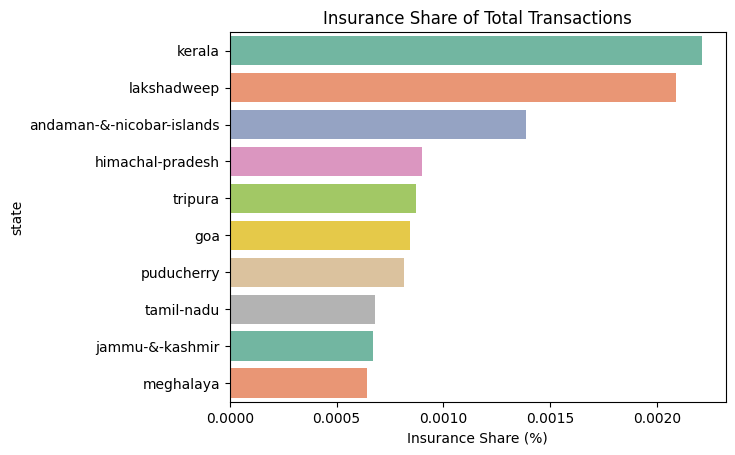

In [81]:
# Bar plot of top 10 states by insurance share in total transactions
sns.barplot(data=df_ins_share.head(10), x='insurance_share', y='state', palette="Set2")
plt.title("Insurance Share of Total Transactions")
plt.xlabel("Insurance Share (%)")
plt.show()

The "Insurance Share of Total Transactions" plot reveals that **Kerala, Lakshadweep, and Andaman & Nicobar Islands** have the highest proportion of insurance transactions relative to their total transactions, with Kerala leading. This suggests that while these regions might not have the highest *absolute* insurance amounts, insurance constitutes a significantly larger *share* of their overall digital payment activity on PhonePe compared to other states, indicating focused engagement with insurance products in these areas.

### 4. Transaction Analysis for Market Expansion

**Scenario:** Operating within a highly competitive digital payments landscape, PhonePe recognizes that a deep understanding of transaction dynamics at a granular level is paramount for strategic decision-making. As transaction volumes grow across diverse regions, the company aims to analyze its data to pinpoint prevailing trends, uncover new opportunities, and identify promising areas for future market expansion.

**Objective:** This analysis provides detailed insights into PhonePe's transaction landscape, crucial for guiding market expansion strategies. By presenting the **top districts and pincodes by total transaction amount**, we identify the most active and high-value geographic micro-markets, underscoring existing strongholds. Concurrently, by showcasing the **top 10 states by maximum quarterly growth percentage**, we highlight rapidly emerging regions that, regardless of their current absolute transaction volume, represent significant untapped potential and strategic opportunities for targeted investment and accelerated market penetration. These insights collectively enable PhonePe to refine its expansion efforts, focusing on both reinforcing dominance in established hubs and aggressively pursuing growth in burgeoning markets.

#### **Districts with Highest Transaction Amount (Map Table)**

**SQL Query**

This SQL query identifies the **top 10 districts by total transaction amount**. It calculates the **sum of `amount`** for each `district` from the `map_transaction` table. The results are then grouped by `district`, ordered in descending order of `txn_amount` (showing the districts with the highest transaction amounts first), and finally `LIMIT`ed to return only the **top 10** districts.

In [82]:
# Top 10 districts by total transaction amount from map_transaction table
df_map_district = pd.read_sql("""
SELECT district, SUM(amount) AS txn_amount
FROM map_transaction
GROUP BY district
ORDER BY txn_amount DESC
LIMIT 10
""", conn)

df_map_district.head(10)

,district,txn_amount
0,bengaluru urban district,1.993784e+13
1,hyderabad district,1.190694e+13
2,pune district,9.730218e+12
3,jaipur district,7.854092e+12
4,rangareddy district,7.155140e+12
5,medchal malkajgiri district,5.758878e+12
6,visakhapatnam district,4.198568e+12
7,guntur district,3.174527e+12
8,krishna district,3.142856e+12
9,patna district,3.110762e+12


**Visualization**

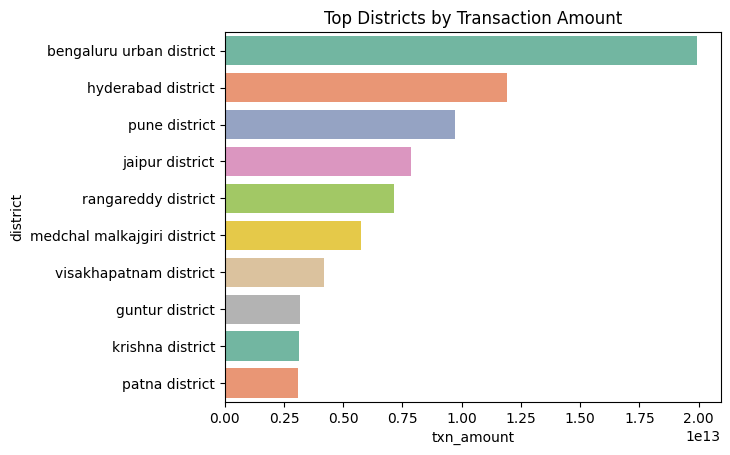

In [83]:
# Bar plot of top districts by transaction amount
sns.barplot(data=df_map_district, x='txn_amount', y='district', palette="Set2")
plt.title("Top Districts by Transaction Amount")
plt.show()

The "Top Districts by Transaction Amount" plot highlights that **Bengaluru Urban District is the undisputed leader** in transaction amount, significantly outperforming all other districts. Hyderabad District and Pune District follow, confirming major urban centers as key hubs for digital transactions. The list generally comprises districts from prominent Indian cities, underscoring the concentration of high-value digital payments in urban and metropolitan areas.

#### **Top 10 Pin Codes by Transaction (Top Table)**

**SQL Query**

This SQL query identifies the **top 10 pincodes by total transaction amount**. It calculates the **sum of `amount`** for each `name` (which represents the pincode) from the `top_map` table. The results are then grouped by `name`, ordered in descending order of `amount` (showing the pincodes with the highest transaction amounts first), and finally `LIMIT`ed to return only the **top 10** pincodes.

In [84]:
# Top 10 pincodes by total transaction amount from top_map table
df_top_pincode = pd.read_sql("""
SELECT name AS pincode, SUM(amount) AS amount
FROM top_map
GROUP BY name
ORDER BY amount DESC
LIMIT 10
""", conn)

df_top_pincode.head(10)

,pincode,amount
0,bengaluru urban,1.993784e+13
1,hyderabad,1.190694e+13
2,pune,9.730218e+12
3,jaipur,7.854092e+12
4,rangareddy,7.155140e+12
5,medchal malkajgiri,5.758878e+12
6,visakhapatnam,4.198568e+12
7,guntur,3.174527e+12
8,patna,3.110762e+12
9,khordha,2.992147e+12


**Visualization**

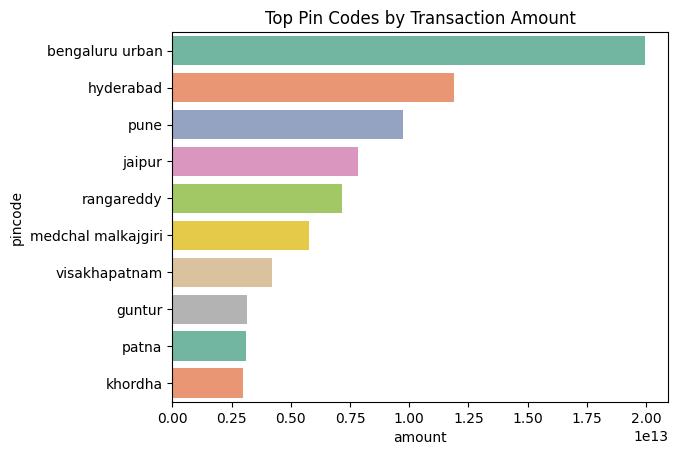

In [85]:
# Bar plot of top pincodes by transaction amount
sns.barplot(data=df_top_pincode, x='amount', y='pincode', palette="Set2")
plt.title("Top Pin Codes by Transaction Amount")
plt.show()

The "Top Pin Codes by Transaction Amount" plot reinforces the pattern observed at the district level, with **Bengaluru Urban (likely representing its central pincodes) dominating** in total transaction amount. Hyderabad and Pune pincodes also show substantial transaction volumes. This indicates that specific urban areas and their corresponding pincodes are the primary engines of high-value digital transactions on the platform, consistent with the activity in major metropolitan districts.

#### **States with Highest Growth Over Time**

**SQL Query**

This code analyzes the **quarterly transaction amount and quarter-on-quarter (QoQ) growth by state**. The SQL query first calculates the **total transaction amount** for each unique combination of `state`, `year`, and `quarter` from the `aggregated_transaction` table, ordering the results chronologically for each state. Following this, the Python code sorts the DataFrame to ensure correct chronological order for each state and then calculates the `growth` column. This `growth` column represents the **percentage change** in `txn_amount` from the previous quarter, specifically within each `state` group, providing the QoQ growth rate.

In [86]:
# Quarterly transaction amount and quarter-on-quarter growth by state
df_growth = pd.read_sql("""
SELECT state, year, quarter, SUM(amount) AS txn_amount
FROM aggregated_transaction
GROUP BY state, year, quarter
ORDER BY state, year, quarter
""", conn)

# Sort and calculate QoQ percentage growth
df_growth.sort_values(["state", "year", "quarter"], inplace=True)
df_growth["growth"] = df_growth.groupby("state")["txn_amount"].pct_change() * 100

**Visualization**

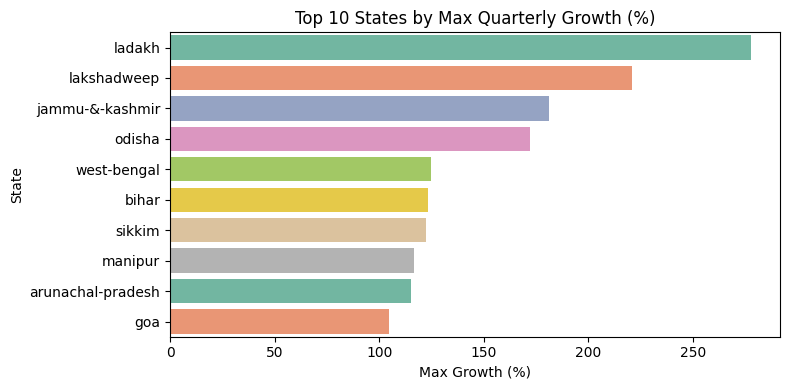

In [87]:
# Top 10 states with highest recorded quarter-on-quarter growth in transactions
top_growth = (
    df_growth.groupby("state")["growth"].max().sort_values(ascending=False).head(10).reset_index()
)

plt.figure(figsize=(8, 4))
sns.barplot(data=top_growth, x="growth", y="state", palette="Set2")
plt.title("Top 10 States by Max Quarterly Growth (%)")
plt.xlabel("Max Growth (%)")
plt.ylabel("State")
plt.tight_layout()
plt.show()

The "Top 10 States by Max Quarterly Growth (%)" plot highlights states that have experienced the most significant single-quarter growth in transaction amounts. **Ladakh and Lakshadweep stand out with exceptionally high maximum quarterly growth rates**, both exceeding 200%. Jammu & Kashmir and Odisha also show very strong growth percentages. This suggests that while these regions might not have the largest absolute transaction volumes, they have seen rapid recent expansion in their digital transaction activity on PhonePe.

### 5. User Engagement and Growth Strategy

**Scenario:** To solidify its market position, PhonePe is focused on deeply analyzing user engagement patterns across various states and districts. Given its substantial base of registered users and high volume of app opens, extracting insights from user behavior is critical for making informed strategic decisions and identifying avenues for sustainable growth.

**Objective:** This analysis provides a comprehensive view of user engagement, essential for crafting effective growth strategies. By presenting the **total registered users per state**, we identify PhonePe's largest user bases, indicating key markets for retention. The **total app opens per state** highlights where the application is most frequently accessed, reflecting overall activity. Crucially, the **app opens per user per state** metric reveals the intensity of engagement, pinpointing regions where users are most active on a per-person basis. This granular understanding enables PhonePe to tailor strategies, from nurturing highly engaged communities to developing initiatives that boost activity in less engaged, but potentially large, user segments.

#### **Top States by Registered Users**

**SQL Query**

This SQL query calculates the **total number of registered users for each state**. It achieves this by summing the `registeredUsers` column from the `map_user` table. The results are then grouped by `state` and ordered in descending order of `users`, presenting the states with the highest number of registered users first.

In [88]:
# Total registered users per state from map_user table
df_users_state = pd.read_sql("""
SELECT state, SUM(registeredUsers) AS users
FROM map_user
GROUP BY state
ORDER BY users DESC
""", conn)

df_users_state

,state,users
0,maharashtra,1140138243
1,uttar-pradesh,942334146
2,karnataka,733674236
3,andhra-pradesh,556747126
4,rajasthan,555774493
5,west-bengal,524964358
6,telangana,524620520
7,tamil-nadu,506486772
8,madhya-pradesh,470663624
9,gujarat,459154666


**Visualization**

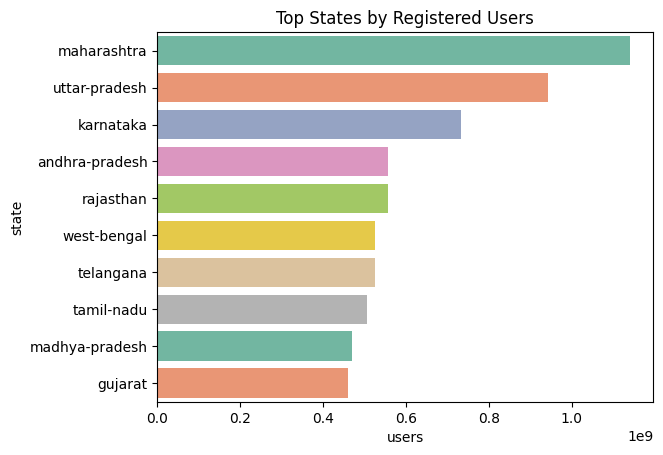

In [89]:
# Bar plot of top 10 states by number of registered users
sns.barplot(data=df_users_state.head(10), y='state', x='users', palette="Set2")
plt.title("Top States by Registered Users")
plt.show()

The "Top States by Registered Users" plot clearly indicates that **Maharashtra leads significantly in the number of registered users**, followed by Uttar Pradesh and Karnataka. This highlights these states as major hubs for PhonePe's user base. The user count gradually decreases down the list, but all states shown have substantial user numbers, reflecting PhonePe's widespread adoption across various populous regions in India.

#### **App Opens by State**

**SQL Query**

This SQL query calculates the **total number of app opens for each state**. It achieves this by summing the `appOpens` column from the `map_user` table. The results are then grouped by `state` and ordered in descending order of `opens`, presenting the states with the highest number of app opens first.

In [90]:
# Total app opens per state from map_user table
df_opens_state = pd.read_sql("""
SELECT state, SUM(appOpens) AS opens
FROM map_user
GROUP BY state
ORDER BY opens DESC
""", conn)

df_opens_state

,state,opens
0,maharashtra,49616423987
1,rajasthan,48507630334
2,madhya-pradesh,39708500796
3,karnataka,38344879267
4,uttar-pradesh,33236833684
5,andhra-pradesh,24728024309
6,telangana,23197773412
7,gujarat,20780416980
8,tamil-nadu,16992199376
9,odisha,14493923288


**Visualization**

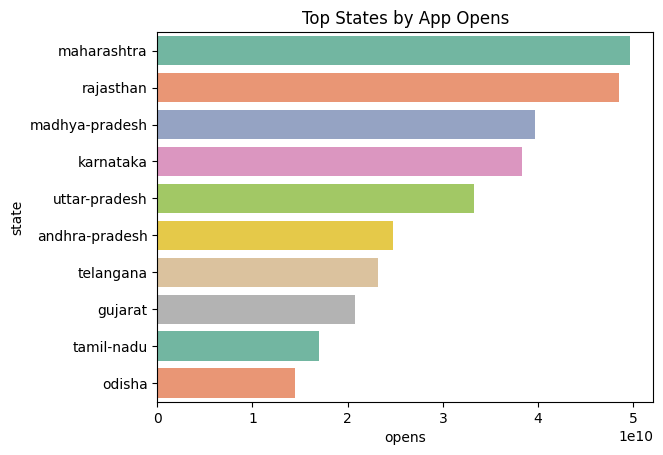

In [91]:
# Bar plot of top 10 states by number of app opens
sns.barplot(data=df_opens_state.head(10), y='state', x='opens', palette="Set2")
plt.title("Top States by App Opens")
plt.show()

The "Top States by App Opens" plot shows that **Maharashtra registers the highest number of app opens**, closely followed by Rajasthan and Madhya Pradesh. While some states like Uttar Pradesh and Karnataka also show high app opens, the leading states indicate strong user engagement and frequent usage of the PhonePe application. This pattern broadly aligns with populous regions, underscoring where the application is most actively utilized.


#### User–App Engagement Ratio

**SQL Query**

This SQL query identifies the **top 10 states by app engagement ratio**, specifically for states with **over 100,000 registered users**. It calculates the total `registeredUsers` and `appOpens` for each `state`. The `engagement_ratio` is then computed as the ratio of `appOpens` to `registeredUsers`, with a `CASE` statement to prevent division by zero and `ROUND` the result. The `HAVING` clause filters these aggregated results to include only states where `users` exceed 100,000, and finally, the output is ordered by `engagement_ratio` in descending order and `LIMIT`ed to the top 10 states.

In [92]:
# Top 10 states by app engagement ratio (appOpens / registeredUsers), filtered for states with >100k users
df_user_ratio = pd.read_sql("""
SELECT state,
       SUM(registeredUsers) AS users,
       SUM(appOpens) AS opens,
       CASE WHEN SUM(registeredUsers) > 0 THEN ROUND(SUM(appOpens)*1.0 / SUM(registeredUsers), 2) ELSE 0 END AS engagement_ratio
FROM map_user
GROUP BY state
HAVING users > 100000
ORDER BY engagement_ratio DESC
LIMIT 10
""", conn)

df_user_ratio

,state,users,opens,engagement_ratio
0,meghalaya,6185282,1078448726,174.36
1,arunachal-pradesh,8046446,1117277209,138.85
2,mizoram,2701061,368884295,136.57
3,ladakh,2271369,294111791,129.49
4,andaman-&-nicobar-islands,1842465,170043693,92.29
5,rajasthan,555774493,48507630334,87.28
6,madhya-pradesh,470663624,39708500796,84.37
7,assam,111842317,9436508709,84.37
8,chhattisgarh,142291017,11190410814,78.64
9,nagaland,6297675,479729729,76.18


**Visualization**

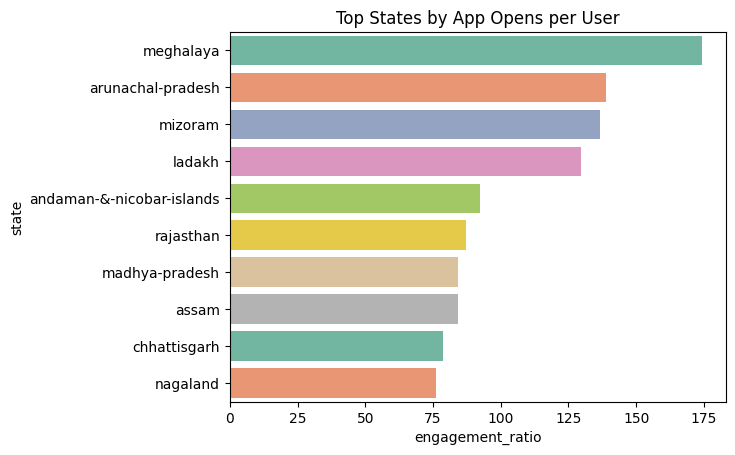

In [93]:
# Bar plot of top states by app opens per registered user (engagement ratio)
sns.barplot(data=df_user_ratio.head(10), x='engagement_ratio', y='state', palette="Set2")
plt.title("Top States by App Opens per User")
plt.show()

The "Top States by App Opens per User" plot highlights states with the highest app engagement ratios. **Meghalaya, Arunachal Pradesh, Mizoram, and Ladakh** exhibit exceptionally high app opens per user, significantly outpacing other states. This indicates that users in these regions, despite potentially having smaller overall user bases, are highly active and frequently engage with the PhonePe application, showcasing strong per-user interaction.

## Conclusion

This comprehensive analysis of PhonePe's transaction dynamics, user engagement, and insurance penetration provides critical insights into the platform's performance and market positioning.

### Key Findings:

* **Robust Growth & Urban Concentration:** PhonePe demonstrates strong, accelerating overall transaction growth across India, heavily concentrated in major states like Telangana, Karnataka, Maharashtra, and urban hotspots such as Bengaluru, Hyderabad, and Pune. Merchant and Peer-to-peer payments are the primary drivers of this growth.
* **Device Ecosystem Dominance:** Xiaomi is the most prevalent device brand among PhonePe users, leading nationally and across the majority of states, followed by Samsung and Vivo. This highlights the importance of optimizing the app for these dominant Android ecosystems.
* **Varied User Engagement:** While a strong positive correlation exists between registered users and app opens, indicating generally healthy engagement, some smaller states like Meghalaya and Ladakh exhibit exceptionally high app opens per user, suggesting deeper per-user engagement in these regions.
* **Growing Insurance Footprint:** The insurance segment on PhonePe is experiencing consistent quarterly growth. Karnataka and Maharashtra lead in absolute insurance amounts, while states like Kerala and Lakshadweep show a remarkably high share of insurance transactions relative to their total digital payments.
* **Emerging Market Opportunities:** Beyond established high-volume regions, states like Ladakh, Lakshadweep, and Jammu & Kashmir are showing exceptionally high quarter-on-quarter growth percentages, indicating significant untapped potential for future market expansion.

### Actionable Recommendations:

1.  **Reinforce Core Markets:** Invest further in high-transaction states (Telangana, Karnataka, Maharashtra) and key urban districts/pincodes (Bengaluru, Hyderabad, Pune) by deepening merchant penetration and enhancing localized user experience to consolidate market leadership.
2.  **Optimize for Dominant Devices:** Prioritize app development and performance optimization for leading device brands like Xiaomi, Samsung, and Vivo to ensure a seamless and superior experience for the majority of the user base.
3.  **Drive Engagement in Key States:** Analyze the success factors contributing to the high engagement ratios in states like Meghalaya and Ladakh. Adapt and implement these learnings through targeted campaigns and personalized features to boost app opens per user in larger states that currently show lower per-user engagement.
4.  **Strategic Insurance Expansion:** Capitalize on the strong growth in the insurance segment. Focus marketing and partnership efforts on high-volume states (Karnataka, Maharashtra) while simultaneously exploring models to replicate the high insurance penetration seen in states like Kerala and Lakshadweep, aiming to increase insurance's share of total transactions in other regions.
5.  **Invest in High-Growth Regions:** Develop tailored market entry and scaling strategies for emerging high-growth states (e.g., Ladakh, Lakshadweep, Jammu & Kashmir). These regions, despite potentially smaller current volumes, offer significant future potential for user acquisition and transaction growth.
6.  **Granular Strategic Planning:** Leverage district and pincode-level insights for hyper-local marketing, sales force deployment, and specific product or service rollouts, ensuring highly targeted and efficient resource allocation.